基于天气数据集的XGBoost分类实战

In [1]:
#导入需要用到的数据集
!wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/7XGBoost/train.csv


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


Step1：函数库导入

In [2]:
##  基础函数库
import numpy as np 
import pandas as pd

## 绘图函数库
import matplotlib.pyplot as plt
import seaborn as sns

Step2：数据读取/载入

In [3]:
## 我们利用Pandas自带的read_csv函数读取并转化为DataFrame格式
data = pd.read_csv('train.csv')

Step3：数据信息简单查看

In [4]:
## 利用.info()查看数据的整体信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106644 entries, 0 to 106643
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           106644 non-null  object 
 1   Location       106644 non-null  object 
 2   MinTemp        106183 non-null  float64
 3   MaxTemp        106413 non-null  float64
 4   Rainfall       105610 non-null  float64
 5   Evaporation    60974 non-null   float64
 6   Sunshine       55718 non-null   float64
 7   WindGustDir    99660 non-null   object 
 8   WindGustSpeed  99702 non-null   float64
 9   WindDir9am     99166 non-null   object 
 10  WindDir3pm     103788 non-null  object 
 11  WindSpeed9am   105643 non-null  float64
 12  WindSpeed3pm   104653 non-null  float64
 13  Humidity9am    105327 non-null  float64
 14  Humidity3pm    103932 non-null  float64
 15  Pressure9am    96107 non-null   float64
 16  Pressure3pm    96123 non-null   float64
 17  Cloud9am       66303 non-null

In [5]:
## 进行简单的数据查看，我们可以利用 .head() 头部.tail()尾部
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2012/1/19,MountGinini,12.1,23.1,0.0,NaN,NaN,W,30.0,N,...,60.0,54.0,NaN,NaN,NaN,NaN,17.0,22.0,No,No
1,2015/4/13,Nhil,10.2,24.7,0.0,NaN,NaN,E,39.0,E,...,63.0,33.0,1021.9,1017.9,NaN,NaN,12.5,23.7,No,Yes
2,2010/8/5,Nuriootpa,-0.4,11.0,3.6,0.4,1.6,W,28.0,N,...,97.0,78.0,1025.9,1025.3,7.0,8.0,3.9,9.0,Yes,No
3,2013/3/18,Adelaide,13.2,22.6,0.0,15.4,11.0,SE,44.0,E,...,47.0,34.0,1025.0,1022.2,NaN,NaN,15.2,21.7,No,No
4,2011/2/16,Sale,14.1,28.6,0.0,6.6,6.7,E,28.0,NE,...,92.0,42.0,1018.0,1014.1,4.0,7.0,19.1,28.2,No,No


这里发现数据集中存在NaN，一般的我们认为NaN在数据集中代表了缺失值，可能是数据采集或处理时产生的一种错误。这里采用-1将缺失值进行填补。

In [6]:
data = data.fillna(-1)

In [7]:
data.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
106639,2011/5/23,Launceston,10.1,16.1,15.8,-1.0,-1.0,SE,31.0,NNW,...,99.0,86.0,999.2,995.2,-1.0,-1.0,13.0,15.6,Yes,Yes
106640,2014/12/9,GoldCoast,19.3,31.7,36.0,-1.0,-1.0,SE,80.0,NNW,...,75.0,76.0,1013.8,1010.0,-1.0,-1.0,26.0,25.8,Yes,Yes
106641,2014/10/7,Wollongong,17.5,22.2,1.2,-1.0,-1.0,WNW,65.0,WNW,...,61.0,56.0,1008.2,1008.2,-1.0,-1.0,17.8,21.4,Yes,No
106642,2012/1/16,Newcastle,17.6,27.0,3.0,-1.0,-1.0,-1,-1.0,NE,...,68.0,88.0,-1.0,-1.0,6.0,5.0,22.6,26.4,Yes,No
106643,2014/10/21,AliceSprings,16.3,37.9,0.0,14.2,12.2,ESE,41.0,NNE,...,8.0,6.0,1017.9,1014.0,0.0,1.0,32.2,35.7,No,No


In [8]:
## 利用value_counts函数查看训练集标签的数量
pd.Series(data['RainTomorrow']).value_counts()


No     82786
Yes    23858
Name: RainTomorrow, dtype: int64

这里输出发现数据集中的负样本数量远大于正样本数量，这种常见的问题叫做“数据不平衡”问题，在某些情况下需要进行一些特殊处理。

In [9]:
## 对于特征进行一些统计描述
data.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000
mean,12.129147,23.183398,2.313912,2.704798,3.509008,37.305137,13.852200,18.265378,67.940353,50.104657,917.003689,914.995385,2.381231,2.285670,16.877842,21.257600
std,6.444358,7.208596,8.379145,4.519172,5.105696,16.585310,8.949659,9.118835,20.481579,22.136917,304.042528,303.120731,3.483751,3.419658,6.629811,7.549532
min,-8.500000,-4.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-7.200000,-5.400000
25%,7.500000,17.900000,0.000000,-1.000000,-1.000000,30.000000,7.000000,11.000000,56.000000,35.000000,1011.000000,1008.500000,-1.000000,-1.000000,12.200000,16.300000
50%,12.000000,22.600000,0.000000,1.600000,0.200000,37.000000,13.000000,17.000000,70.000000,51.000000,1016.700000,1014.200000,1.000000,1.000000,16.700000,20.900000
75%,16.800000,28.300000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000
max,31.900000,48.100000,268.600000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,39.400000,46.200000


Step4:可视化描述

In [10]:
numerical_features = [x for x in data.columns if data[x].dtype == np.float]

category_features = [x for x in data.columns if data[x].dtype != np.float and x != 'RainTomorrow']


C:\Users\cmy\AppData\Local\Temp/ipykernel_7096/3068768111.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numerical_features = [x for x in data.columns if data[x].dtype == np.float]
C:\Users\cmy\AppData\Local\Temp/ipykernel_7096/3068768111.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  category_features = [x for x in data.columns

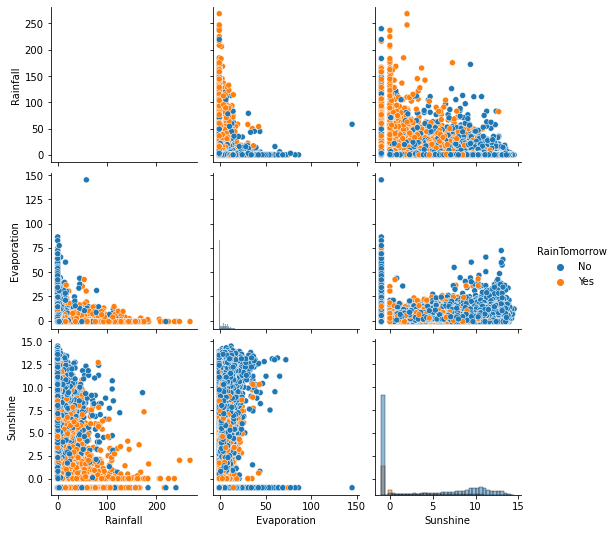

In [11]:
## 选取三个特征与标签组合的散点可视化
sns.pairplot(data=data[['Rainfall',
'Evaporation',
'Sunshine'] + ['RainTomorrow']], diag_kind='hist', hue= 'RainTomorrow')
plt.show()


从上图可以发现，在2D情况下不同的特征组合对于第二天下雨与不下雨的散点分布，以及大概的区分能力。相对的Sunshine与其他特征的组合更具有区分能力。

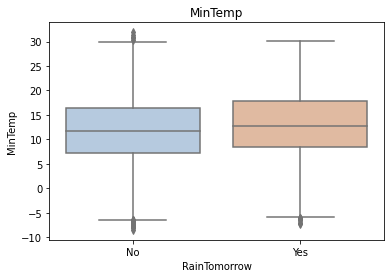

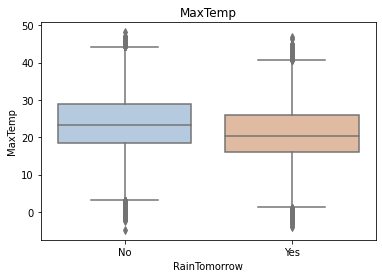

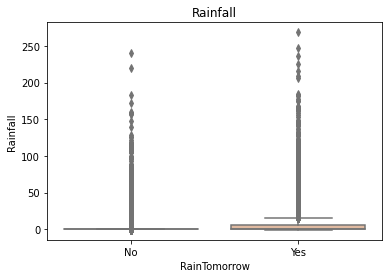

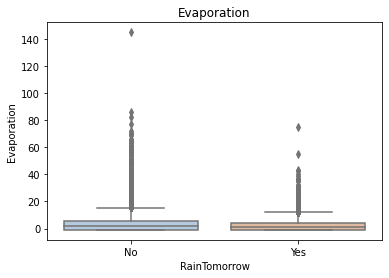

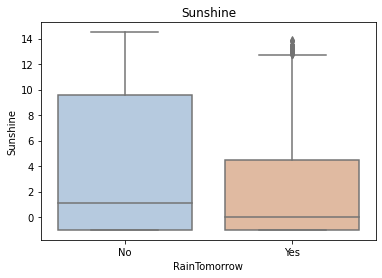

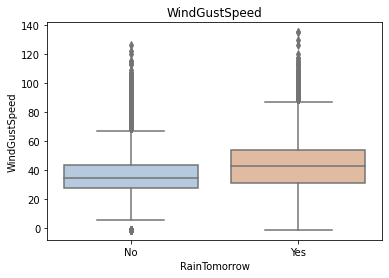

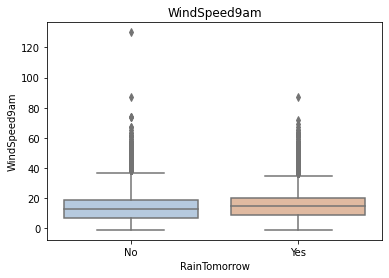

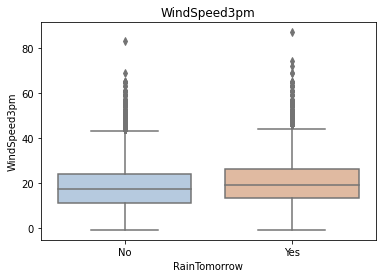

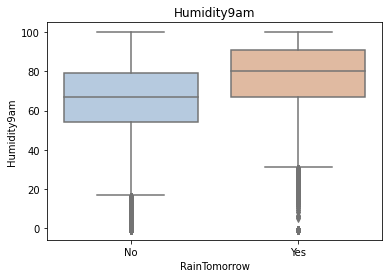

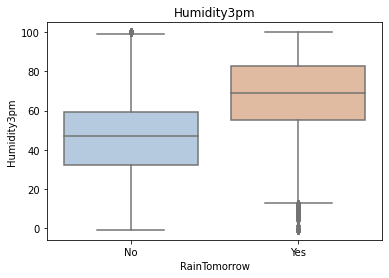

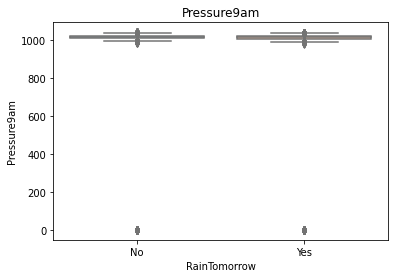

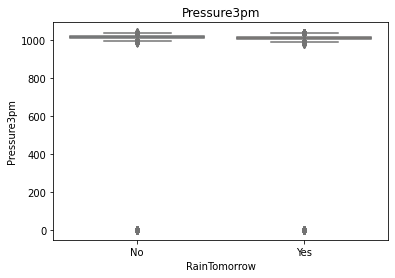

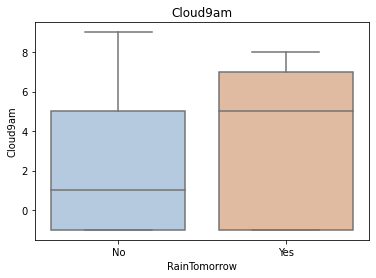

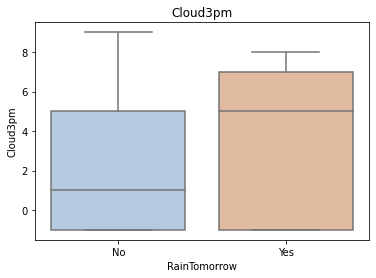

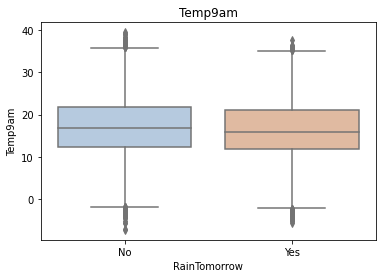

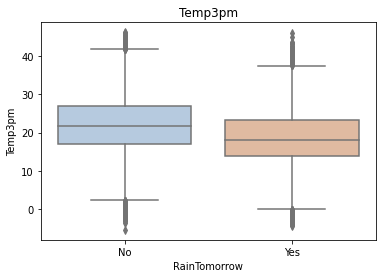

In [12]:
for col in data[numerical_features].columns:
    if col != 'RainTomorrow':
        sns.boxplot(x='RainTomorrow', y=col, saturation=0.5, palette='pastel', data=data)
        plt.title(col)
        plt.show()


利用箱型图我们也可以得到不同类别在不同特征上的分布差异情况。我们可以发现Sunshine,Humidity3pm,Cloud9am,Cloud3pm的区分能力较强.

In [13]:
tlog = {}
for i in category_features:
    tlog[i] = data[data['RainTomorrow'] == 'Yes'][i].value_counts()
flog = {}
for i in category_features:
    flog[i] = data[data['RainTomorrow'] == 'No'][i].value_counts()

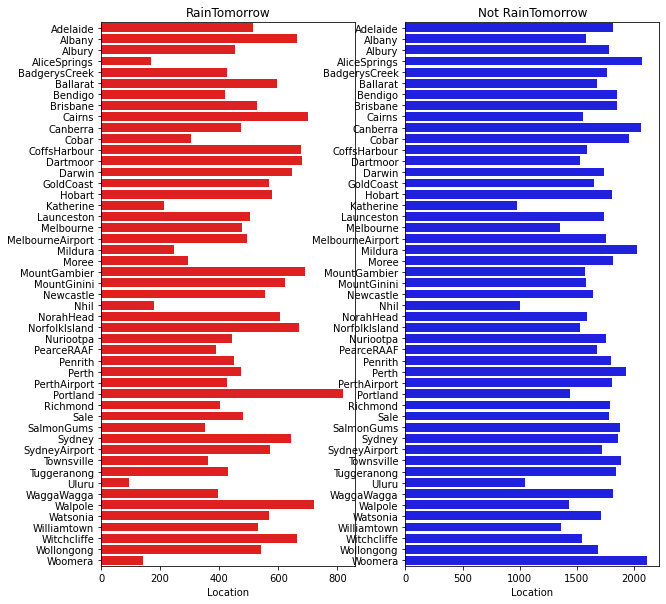

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
sns.barplot(x = pd.DataFrame(tlog['Location']).sort_index()['Location'], y = pd.DataFrame(tlog['Location']).sort_index().index, color = "red")
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x = pd.DataFrame(flog['Location']).sort_index()['Location'], y = pd.DataFrame(flog['Location']).sort_index().index, color = "blue")
plt.show()

从上图可以发现不同地区降雨情况差别很大，有些地方明显更容易降雨。

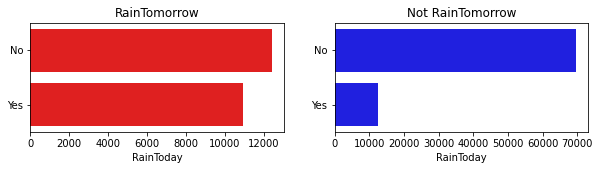

In [15]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
sns.barplot(x = pd.DataFrame(tlog['RainToday'][:2]).sort_index()['RainToday'], y = pd.DataFrame(tlog['RainToday'][:2]).sort_index().index, color = "red")
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x = pd.DataFrame(flog['RainToday'][:2]).sort_index()['RainToday'], y = pd.DataFrame(flog['RainToday'][:2]).sort_index().index, color = "blue")
plt.show()


从上图可以发现，今天下雨明天不一定下雨，但今天不下雨，第二天大概率也不下雨。

Step5:对离散变量进行编码
由于XGBoost无法处理字符串类型的数据，所以需要一些方法讲字符串数据转化为数据。一种最简单的方法是把所有的相同类别的特征编码成同一个值，例如女=0，男=1，狗=2，所以最后编码的特征值是在[ 0 , 特 征 数 量 − 1 ] [0, 特征数量-1][0,特征数量−1]之间的整数。除此之外，还有独热编码、求和编码、留一法编码等等方法可以获得更好的效果。

In [16]:
## 把所有的相同类别的特征编码为同一个值
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
for i in category_features:
    data[i] = data[i].apply(get_mapfunction(data[i]))


In [17]:
## 编码后的字符串特征变成了数字

data['Location'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

Step6：利用 XGBoost 进行训练与预测

In [18]:
## 为了正确评估模型性能，将数据划分为训练集和测试集，并在训练集上训练模型，在测试集上验证模型性能。
from sklearn.model_selection import train_test_split

## 选择其类别为0和1的样本 （不包括类别为2的样本）
data_target_part = data['RainTomorrow']
data_features_part = data[[x for x in data.columns if x != 'RainTomorrow']]

## 测试集大小为20%， 80%/20%分
x_train, x_test, y_train, y_test = train_test_split(data_features_part, data_target_part, test_size = 0.2, random_state = 2020)


In [19]:
## 导入XGBoost模型
from xgboost.sklearn import XGBClassifier
## 定义 XGBoost模型 
clf = XGBClassifier()
# 在训练集上训练XGBoost模型
clf.fit(x_train, y_train)


C:\Users\cmy\.virtualenvs\cmy-4dIGUrJg\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The accuracy of the Logistic Regression is: 0.8982476703979371
The accuracy of the Logistic Regression is: 0.8575179333302076
The confusion matrix result:
 [[15656  2142]
 [  897  2634]]


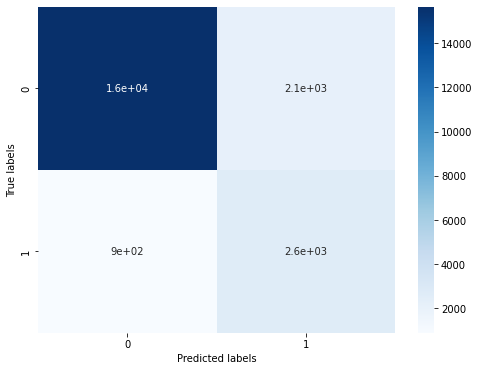

In [20]:
## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


可以发现有15656+2634个样本预测正确，2142+897个样本预测错误

Step7：利用XGBoost进行特征选择
XGBoost的特征选择属于特征选择中的嵌入式方法，在XGboost中可以用属性feature_importances_去查看特征的重要度。

<AxesSubplot:>

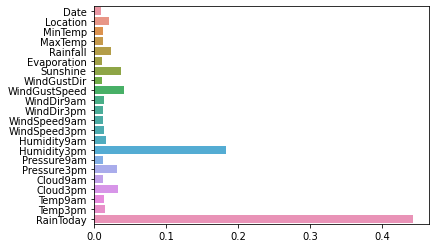

In [21]:
sns.barplot(y=data_features_part.columns, x=clf.feature_importances_)


从图中可以发现下午3点的湿度与今天是否下雨是决定第二天是否下雨最重要的因素。

除此之外，还可以使用XGBoost中的下列重要属性来评估特征的重要性。

weight:是以特征用到的次数来评价
gain:当利用特征做划分的时候的评价基尼指数
cover:利用一个覆盖样本的指标二阶导数（具体原理不清楚有待探究）平均值来划分。
total_gain:总基尼指数
total_cover:总覆盖

C:\Users\cmy\.virtualenvs\cmy-4dIGUrJg\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


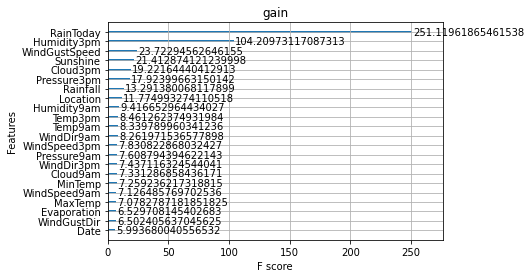

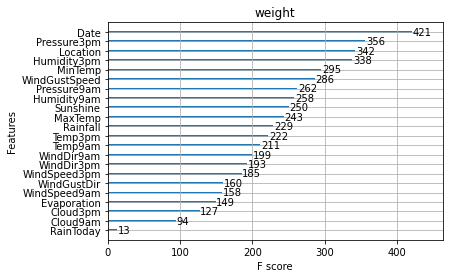

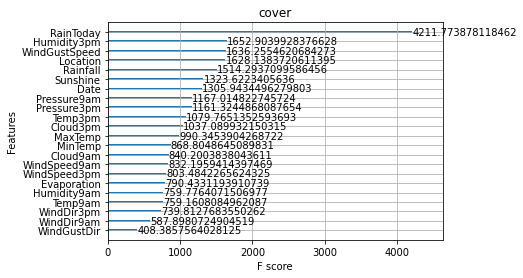

acc= 0.8575179333302076


In [22]:
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

def estimate(model,data):

    #sns.barplot(data.columns,model.feature_importances_)
    ax1=plot_importance(model,importance_type="gain")
    ax1.set_title('gain')
    ax2=plot_importance(model, importance_type="weight")
    ax2.set_title('weight')
    ax3 = plot_importance(model, importance_type="cover")
    ax3.set_title('cover')
    plt.show()
def classes(data,label,test):
    model=XGBClassifier()
    model.fit(data,label)
    ans=model.predict(test)
    estimate(model, data)
    return ans
 
ans=classes(x_train,y_train,x_test)
pre=accuracy_score(y_test, ans)
print('acc=',accuracy_score(y_test,ans))



Step8: 通过调整参数获得更好的效果
XGBoost中包括但不限于下列对模型影响较大的参数：

learning_rate: 有时也叫作eta，系统默认值为0.3。每一步迭代的步长，很重要。太大了运行准确率不高，太小了运行速度慢。
subsample：系统默认为1。这个参数控制对于每棵树，随机采样的比例。减小这个参数的值，算法会更加保守，避免过拟合, 取值范围零到一。
colsample_bytree：系统默认值为1。我们一般设置成0.8左右。用来控制每棵随机采样的列数的占比(每一列是一个特征)。
max_depth： 系统默认值为6，我们常用3-10之间的数字。这个值为树的最大深度。这个值是用来控制过拟合的。max_depth越大，模型学习的更加具体。
调节模型参数的方法有贪心算法、网格调参、贝叶斯调参等。这里我们采用网格调参，它的基本思想是穷举搜索：在所有候选的参数选择中，通过循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果。

In [23]:
## 从sklearn库中导入网格调参函数
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## 定义参数取值范围
learning_rate = [0.1, 0.3, 0.6]
subsample = [0.8, 0.9]
colsample_bytree = [0.6, 0.8]
max_depth = [3,5,8]

parameters = { 'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree':colsample_bytree,
              'max_depth': max_depth}
model = XGBClassifier(n_estimators = 50)

## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy',verbose=1,n_jobs=-1)
clf = clf.fit(x_train, y_train)

## 网格搜索后的最好参数为
clf.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\cmy\.virtualenvs\cmy-4dIGUrJg\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 8,
 'subsample': 0.8}

[14:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of the Logistic Regression is: 0.9434917658090606
The accuracy of the Logistic Regression is: 0.8577992404707206
The confusion matrix result:
 [[15639  2119]
 [  914  2657]]


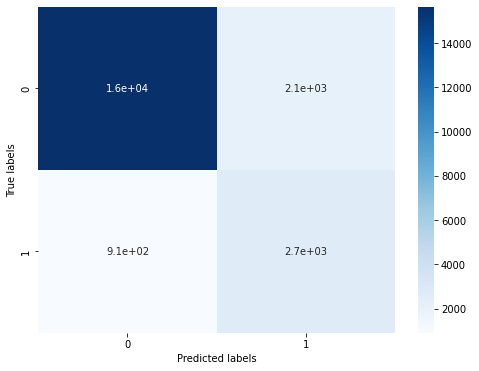

In [24]:
## 在训练集和测试集上分布利用最好的模型参数进行预测

## 定义带参数的 XGBoost模型 
clf = XGBClassifier(colsample_bytree = 0.6, learning_rate = 0.3, max_depth= 8, subsample = 0.9)
# 在训练集上训练XGBoost模型
clf.fit(x_train, y_train)

train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


原本有2142+897个错误，现在有2119+914个错误，带来了明显的正确率提升。